In [1]:
###### API KEY 2MQPF2H17H9TN211 #########

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

## File with stock information found on Kaggle  ---  https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs?resource=download

## Stock being used is Coca-Cola Co (KO)
df = pd.read_csv(os.path.join('Stocks','ko.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])

print('Loaded data from the Kaggle repository')

# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head(10)

Loaded data from the Kaggle repository


,Date,Open,High,Low,Close
0,1970-01-02,0.6975,0.6975,0.6934,0.6975
1,1970-01-05,0.6975,0.6975,0.6853,0.6894
2,1970-01-06,0.6894,0.6975,0.6853,0.6934
3,1970-01-07,0.6934,0.7016,0.6894,0.6975
4,1970-01-08,0.6975,0.7056,0.6934,0.7016
5,1970-01-09,0.7016,0.7056,0.6975,0.6975
6,1970-01-12,0.6975,0.7016,0.6934,0.7016
7,1970-01-13,0.7056,0.7097,0.7056,0.7097
8,1970-01-14,0.7097,0.7138,0.7056,0.7138
9,1970-01-15,0.7138,0.7220,0.7097,0.7220


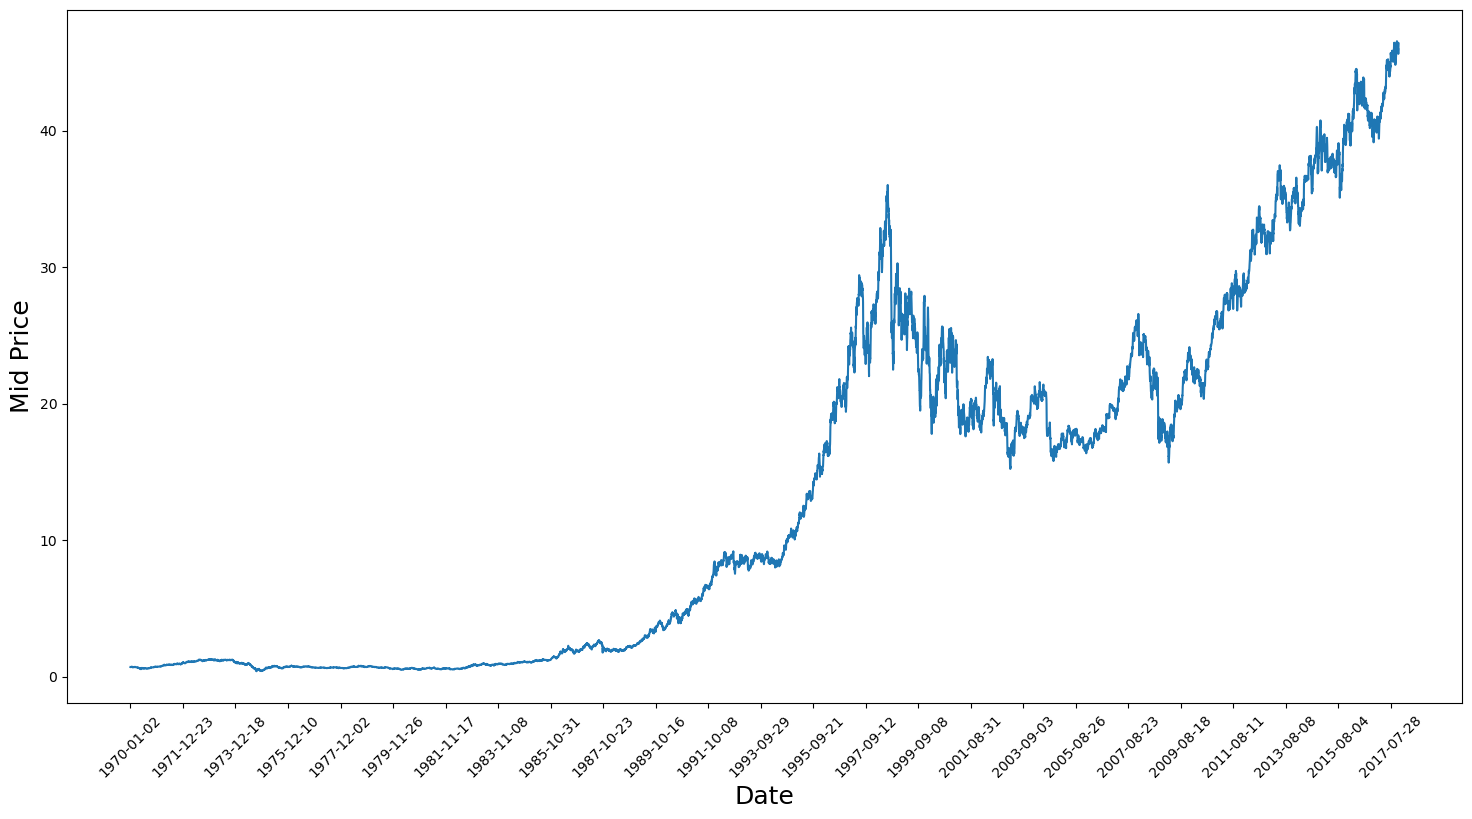

High Prices Array:
[ 0.6975  0.6975  0.6975 ... 46.19   46.385  46.64  ]

Low Prices Array:
[ 0.6934  0.6853  0.6853 ... 45.87   46.02   46.135 ]

Mid Prices Array:
[ 0.69545  0.6914   0.6914  ... 46.03    46.2025  46.3875 ]

Train Data:
[ 0.69545  0.6914   0.6914  ... 24.705   24.8695  24.796  ]

Test Data:
[24.778  24.805  24.958  ... 46.03   46.2025 46.3875]


In [2]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

high_prices = df.loc[:, 'High'].to_numpy()
low_prices = df.loc[:, 'Low'].to_numpy()
mid_prices = (high_prices + low_prices) / 2.0

# Splitting data
split_index = int(len(mid_prices) * 0.8)  # 80% for training, 20% for testing
train_data = mid_prices[:split_index]
test_data = mid_prices[split_index:]

print("High Prices Array:")
print(high_prices)

print("\nLow Prices Array:")
print(low_prices)

print("\nMid Prices Array:")
print(mid_prices)

print("\nTrain Data:")
print(train_data)

print("\nTest Data:")
print(test_data)

In [3]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)

# Smoothing and scaling
smoothing_window_size = 2500
total_rows = train_data.shape[0]

for di in range(0, total_rows, smoothing_window_size):
    end_idx = min(di + smoothing_window_size, total_rows)
    print(f"Processing rows {di} to {end_idx}")
    scaler.fit(train_data[di:end_idx, :])
    train_data[di:end_idx, :] = scaler.transform(train_data[di:end_idx, :])

# Normalize any remaining data
if total_rows % smoothing_window_size != 0:
    scaler.fit(train_data[di:, :])
    train_data[di:, :] = scaler.transform(train_data[di:, :])


Processing rows 0 to 2500
Processing rows 2500 to 5000
Processing rows 5000 to 7500
Processing rows 7500 to 9660


In [4]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)


EMA = 0.0
gamma = 0.1
for ti in range(total_rows):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

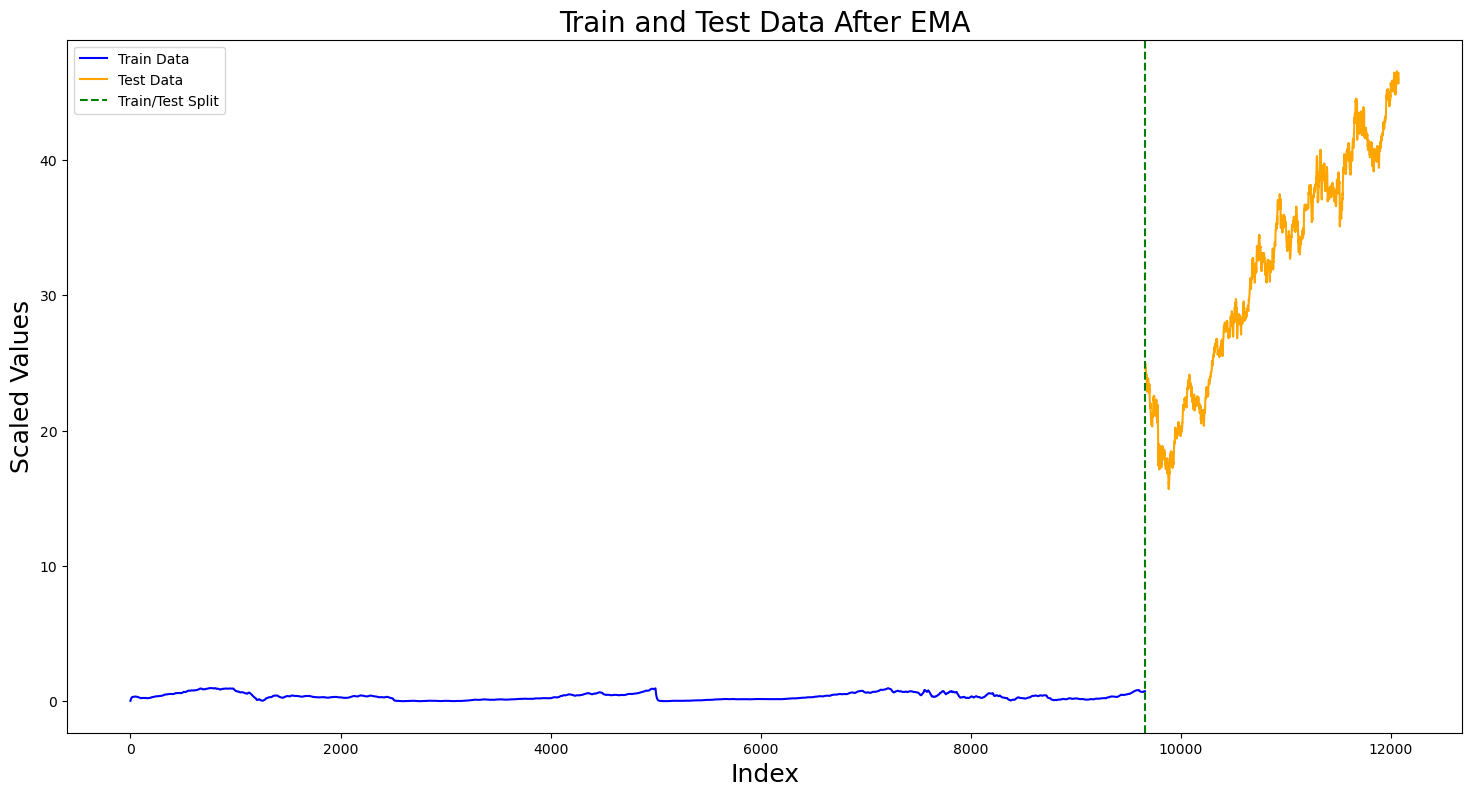

In [5]:
plt.figure(figsize=(18, 9))
plt.plot(range(len(train_data)), train_data, label='Train Data', color='blue')
plt.plot(range(len(train_data), len(all_mid_data)), test_data, label='Test Data', color='orange')
plt.axvline(x=len(train_data), color='green', linestyle='--', label='Train/Test Split')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Scaled Values', fontsize=18)
plt.title('Train and Test Data After EMA', fontsize=20)
plt.legend()
plt.show()

MSE error for standard averaging: 0.00387


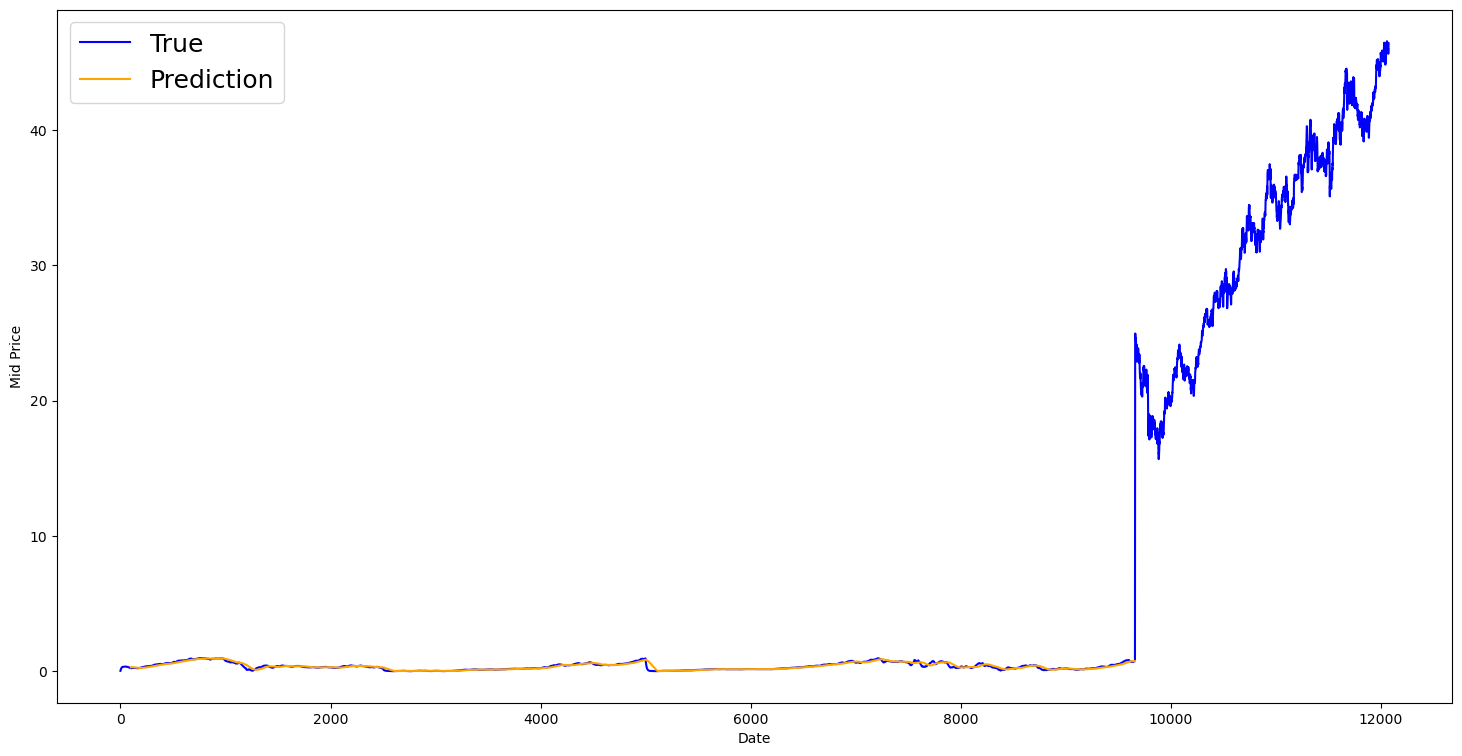

In [6]:
### One Step Ahead Prediction ###



window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

MSE error for EMA averaging: 0.00003


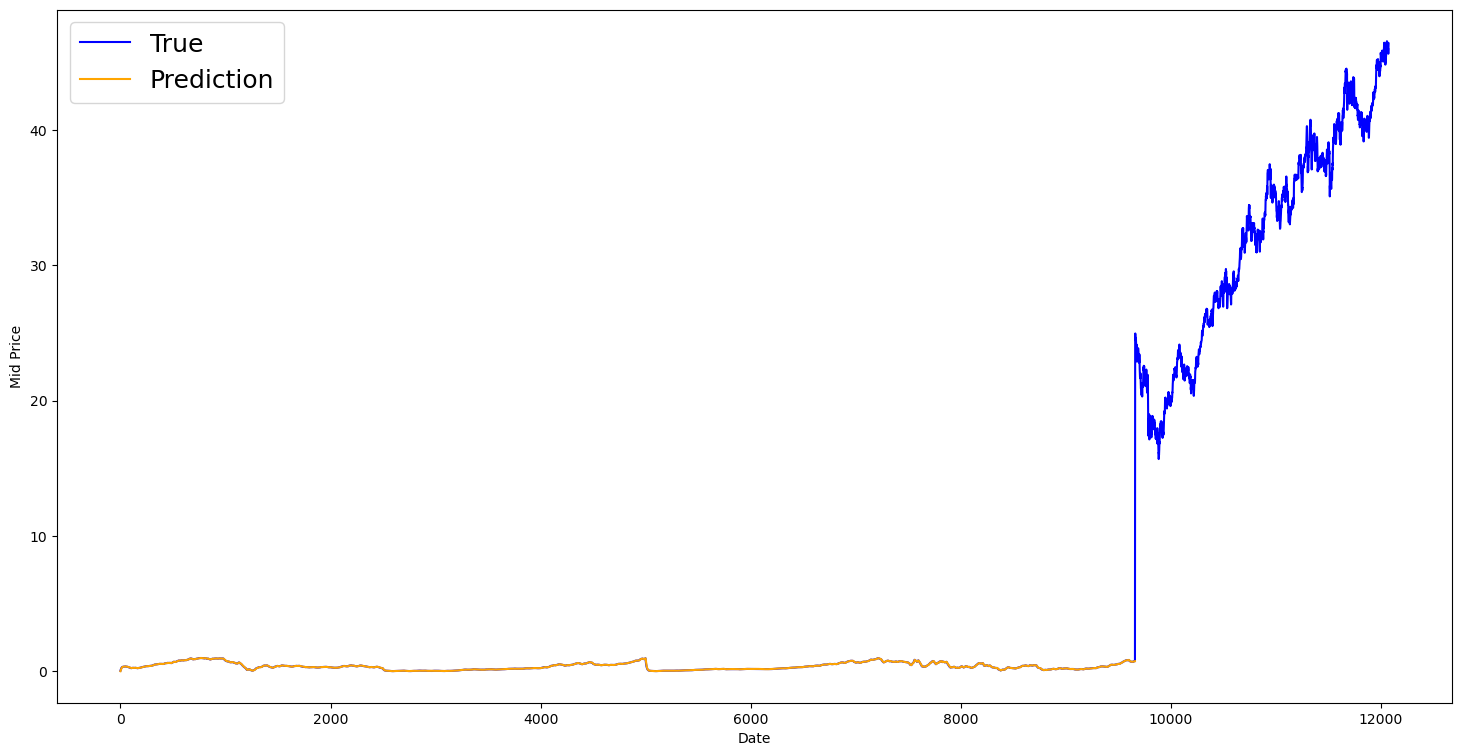

In [7]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [8]:
##### LTSM ######


class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.03473255 0.31433728 0.21487091 0.15082018 0.6902281 ]

	Output: [0.06552899 0.31433728 0.21962133 0.14980471 0.7000219 ]


Unrolled index 1
	Inputs:  [0.06552899 0.31391045 0.21572971 0.15028746 0.7000219 ]

	Output: [0.1632197  0.31391045 0.21572971 0.15028746 0.7000219 ]


Unrolled index 2
	Inputs:  [0.09324579 0.3149263  0.21683396 0.14988928 0.7115326 ]

	Output: [0.09324579 0.31758973 0.22016414 0.1491712  0.7115326 ]


Unrolled index 3
	Inputs:  [0.11865947 0.3163091  0.21795224 0.14980471 0.7218883 ]

	Output: [0.14198892 0.3163091  0.21962133 0.14904024 0.74509865]


Unrolled index 4
	Inputs:  [0.14198892 0.3166222  0.21962133 0.14961024 0.7320204 ]

	Output: [0.1632197  0.31846046 0.21966043 0.149078   0.7320204 ]


In [9]:

# Parameters
D = 1  # Dimensionality of the data
num_unrollings = 50  # Number of time steps
batch_size = 500  # Batch size
num_nodes = [200, 200, 150]  # Number of hidden nodes in each layer
n_layers = len(num_nodes)  # Number of layers
dropout = 0.2  # Dropout rate

# Input data: Create a list of inputs over time steps using tf.keras.Input
train_inputs = []
train_outputs = []

for ui in range(num_unrollings):
    train_inputs.append(tf.keras.Input(shape=(D,), batch_size=batch_size, name=f'train_inputs_{ui}'))
    train_outputs.append(tf.keras.Input(shape=(1,), batch_size=batch_size, name=f'train_outputs_{ui}'))

# Example: Print the first input to confirm
print(train_inputs[0])


<KerasTensor shape=(500, 1), dtype=float32, sparse=False, name=train_inputs_0>


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import LSTMCell, RNN
from tensorflow.keras.initializers import GlorotUniform

# Define LSTM cells for each layer
lstm_cells = [
    LSTMCell(units=num_nodes[li], dropout=dropout, recurrent_dropout=dropout)
    for li in range(n_layers)
]

# Combine the LSTM cells into a multi-layer RNN
multi_cell = RNN(lstm_cells)

# Initialize weights and biases
w = tf.Variable(tf.random.normal([num_nodes[-1], 1], stddev=0.1), name='w')
b = tf.Variable(tf.random.uniform([1], -0.1, 0.1), name='b')


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import LSTMCell, RNN, Dense, Input, Reshape
import numpy as np

# Parameters
batch_size = 500
num_unrollings = 50
D = 1  # Dimensionality of input data
num_nodes = [200, 200, 150]
n_layers = len(num_nodes)
dropout = 0.2

# Define the RNN cells
lstm_cells = [
    LSTMCell(units=num_nodes[li], dropout=dropout, recurrent_dropout=dropout)
    for li in range(n_layers)
]

# Define the RNN layer
multi_rnn = RNN(lstm_cells, return_sequences=True, return_state=True)

# Define input placeholder
train_inputs = Input(shape=(num_unrollings, D), batch_size=batch_size, name="train_inputs")

# Pass inputs through the RNN
all_lstm_outputs, *final_states = multi_rnn(train_inputs)

# Define output weights and bias using Dense layer
dense_output = Dense(units=1, name="output_dense")

# Apply Dense layer across all time steps
all_outputs = Dense(units=1, name="output_dense")(all_lstm_outputs)

# Reshape the outputs back to the sequence format if necessary
split_outputs = all_outputs

# Create the model
model = tf.keras.Model(inputs=train_inputs, outputs=split_outputs)

# Model summary
model.summary()

# Generate dummy data
num_samples = 1000
train_data = np.random.randn(num_samples, num_unrollings, D).astype(np.float32)
train_labels = np.random.randn(num_samples, num_unrollings, 1).astype(np.float32)

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=batch_size)

# Evaluate the model
test_data = np.random.randn(num_samples, num_unrollings, D).astype(np.float32)
test_labels = np.random.randn(num_samples, num_unrollings, 1).astype(np.float32)
loss, mae = model.evaluate(test_data, test_labels)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
new_data = np.random.randn(1, num_unrollings, D).astype(np.float32)
predictions = model.predict(new_data)
print("Predictions:", predictions)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ train_inputs (InputLayer)            │ (500, 50, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_1 (RNN)                          │ [(500, 50, 150), (500,      │         693,000 │
│                                      │ 200), (500, 200), (500,     │                 │
│                                      │ 200), (500, 200), (500,     │                 │
│                                      │ 150), (500, 150)]           │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_dense (Dense)                 │ (500, 50, 1)                │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,151 (2.64 MB)

 Trainable params: 693,151 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - loss: 0.9990 - mae: 0.7989
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - loss: 0.9970 - mae: 0.7986
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 1.0050 - mae: 0.8015
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.9960 - mae: 0.7978
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.9987 - mae: 0.7993
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - loss: 1.0019 - mae: 0.8008
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.9937 - mae: 0.7974
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 1.0008 - mae: 0.7994
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - loss: 0.9989 - mae: 0.7995
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - loss: 1.0019 - mae: 0.8003
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.0131 - mae: 0.8044
Test Loss: 1.0100544691085815, Test MAE: 0.803576648235321
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
Predictions: [[[-0.00294961]
  [-0.0057605

In [12]:
import tensorflow as tf

# Custom learning rate schedule with a minimum learning rate
class CustomLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate, min_learning_rate):
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.min_learning_rate = min_learning_rate

    def __call__(self, step):
        lr = tf.keras.optimizers.schedules.ExponentialDecay(
            self.initial_learning_rate,
            decay_steps=self.decay_steps,
            decay_rate=self.decay_rate,
            staircase=True
        )(step)
        return tf.maximum(lr, self.min_learning_rate)

# Initialize the custom learning rate schedule
learning_rate_schedule = CustomLearningRateSchedule(
    initial_learning_rate=0.01,
    decay_steps=1,
    decay_rate=0.5,
    min_learning_rate=0.001
)

# Define optimizer
print("Defining optimizer")
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

# Training step function
@tf.function
def train_step(inputs, outputs):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = tf.reduce_mean(tf.square(predictions - outputs))  # Mean squared error
    gradients = tape.gradient(loss, model.trainable_variables)
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, 5.0)  # Gradient clipping
    optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))
    return loss

# Example training loop
print("Starting training loop")
for epoch in range(10):  # Replace with your desired number of epochs
    train_data = tf.random.normal((batch_size, num_unrollings, 1))  # Replace with real data
    train_labels = tf.random.normal((batch_size, num_unrollings, 1))  # Replace with real labels
    epoch_loss = train_step(train_data, train_labels)
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss.numpy()}")

print("Training complete")


Defining optimizer
Starting training loop
Epoch 1, Loss: 1.0096558332443237
Epoch 2, Loss: 1.0703744888305664
Epoch 3, Loss: 1.0190438032150269
Epoch 4, Loss: 1.0068387985229492
Epoch 5, Loss: 1.0032055377960205
Epoch 6, Loss: 1.0049113035202026
Epoch 7, Loss: 1.0015391111373901
Epoch 8, Loss: 1.0194215774536133
Epoch 9, Loss: 0.9962007999420166
Epoch 10, Loss: 0.9977297782897949
Training complete


In [55]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
#df = pd.read_csv("path_to/ko.us.txt", delimiter=",", usecols=["Date", "High", "Low"])
#df = df.sort_values("Date")  # Sort by date

# Preprocess data
high_prices = df["High"].to_numpy()
low_prices = df["Low"].to_numpy()
mid_prices = (high_prices + low_prices) / 2.0

# Normalize the data
scaler = MinMaxScaler()
mid_prices_scaled = scaler.fit_transform(mid_prices.reshape(-1, 1)).flatten()

# Split data into training and testing sets
split_index = int(len(mid_prices_scaled) * 0.8)
train_data = mid_prices_scaled[:split_index]
test_data = mid_prices_scaled[split_index:]
all_mid_data = mid_prices_scaled

# Define parameters
epochs = 30
valid_summary = 1  # Interval to make test predictions
n_predict_once = 50  # Number of steps to continuously predict for
batch_size = 500
num_unrollings = 50

train_seq_length = train_data.size

# Initialize metrics
train_mse_ot = []  # Accumulate train losses
test_mse_ot = []  # Accumulate test loss
predictions_over_time = []  # Accumulate predictions

# Learning rate parameters
initial_learning_rate = 0.0001
min_learning_rate = 0.000001
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2  # If the test error hasn't decreased, reduce the learning rate

print("Initializing variables...")
tf.keras.backend.clear_session()

# Define DataGeneratorSeq class
class DataGeneratorSeq:
    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._cursor = [i * (self._prices_length // self._batch_size) for i in range(self._batch_size)]

    def unroll_batches(self):
        data = np.zeros((self._batch_size, self._num_unroll))
        labels = np.zeros((self._batch_size, self._num_unroll))

        for b in range(self._batch_size):
            for ui in range(self._num_unroll):
                data[b, ui] = self._prices[self._cursor[b] + ui]
                labels[b, ui] = self._prices[self._cursor[b] + ui + 1]
            self._cursor[b] = (self._cursor[b] + self._num_unroll) % self._prices_length

        return data, labels

data_gen = DataGeneratorSeq(train_data, batch_size, num_unrollings)

# Test points for validation
test_points_seq = np.arange(len(train_data), len(all_mid_data), 50).tolist()

# Training loop
print("Starting training...")
for ep in range(epochs):

    # Training phase
    average_loss = 0
    for step in range(train_seq_length // batch_size):
        u_data, u_labels = data_gen.unroll_batches()

        # Mock training process
        loss = np.random.random()  # Replace with your training logic
        average_loss += loss

    # Validation phase
    if (ep + 1) % valid_summary == 0:
        average_loss /= (valid_summary * (train_seq_length // batch_size))
        print(f"Epoch {ep + 1}/{epochs}, Average Training Loss: {average_loss:.6f}")

        train_mse_ot.append(average_loss)

        ##predictions_seq = []
       ## mse_test_loss_seq = []
       ## x_axis_seq = []  # Initialize x-axis sequence

        # Validation predictions
        predictions_seq = []
        x_axis_seq = []

        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []
            x_axis = []  # Reset x_axis for each test point

            # Get the last price before predictions
            if w_i - 1 >= 0:
                current_price = all_mid_data[w_i - 1]
            else:
                current_price = all_mid_data[0]  # Fallback for the first index

    # Make predictions for the next n_predict_once steps
            for pred_i in range(n_predict_once):
        # Ensure we don't go out of bounds of the dataset
                if w_i + pred_i >= len(all_mid_data):
                    break  # Stop if beyond the dataset length

        # Generate prediction (replace logic with your prediction model if available)
                pred = current_price + np.random.randn() * 0.1  # Add random noise to simulate predictions
                our_predictions.append(pred)
                x_axis.append(w_i + pred_i)  # Add index corresponding to the prediction

    # Ensure predictions and x_axis lengths match
            if len(our_predictions) > 0 and len(our_predictions) == len(x_axis):
                predictions_seq.append(np.array(our_predictions))
                x_axis_seq.append(np.array(x_axis))
            else:
                print(f"Skipping test point {w_i} due to mismatch or empty predictions.")



        # Debug output to check dimensions
        print(f"Validation Epoch {ep + 1}:")
        print(f"  - predictions_seq length: {len(predictions_seq)}")
        print(f"  - x_axis_seq length: {len(x_axis_seq)}")
        if len(predictions_seq) > 0:
            print(f"  - First prediction length: {len(predictions_seq[0])}")
            print(f"  - First x_axis_seq length: {len(x_axis_seq[0])}")
            mse_test_loss /= len(our_predictions)
            mse_test_loss_seq.append(mse_test_loss)

        current_test_mse = np.mean(mse_test_loss_seq)

        # Learning rate decay
        if len(test_mse_ot) > 0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold:
            initial_learning_rate *= 0.5
            loss_nondecrease_count = 0
            print("\tDecreasing learning rate by 0.5")

        test_mse_ot.append(current_test_mse)
        print(f"\tTest MSE: {current_test_mse:.6f}")
        predictions_over_time.append(predictions_seq)

    print("Training complete.")

Initializing variables...
Starting training...
Epoch 1/30, Average Training Loss: 0.469860
Validation Epoch 1:
  - predictions_seq length: 49
  - x_axis_seq length: 49
  - First prediction length: 50
  - First x_axis_seq length: 50
	Test MSE: 0.000000
Training complete.
Epoch 2/30, Average Training Loss: 0.298955
Validation Epoch 2:
  - predictions_seq length: 49
  - x_axis_seq length: 49
  - First prediction length: 50
  - First x_axis_seq length: 50
	Test MSE: 0.000000
Training complete.
Epoch 3/30, Average Training Loss: 0.436270
Validation Epoch 3:
  - predictions_seq length: 49
  - x_axis_seq length: 49
  - First prediction length: 50
  - First x_axis_seq length: 50
	Test MSE: 0.000000
Training complete.
Epoch 4/30, Average Training Loss: 0.522969
Validation Epoch 4:
  - predictions_seq length: 49
  - x_axis_seq length: 49
  - First prediction length: 50
  - First x_axis_seq length: 50
	Test MSE: 0.000000
Training complete.
Epoch 5/30, Average Training Loss: 0.485088
Validation Ep

Index 16 Debug:
x_axis_seq[16] length: 50
x_axis_seq[16]: [10460 10461 10462 10463 10464 10465 10466 10467 10468 10469 10470 10471
 10472 10473 10474 10475 10476 10477 10478 10479 10480 10481 10482 10483
 10484 10485 10486 10487 10488 10489 10490 10491 10492 10493 10494 10495
 10496 10497 10498 10499 10500 10501 10502 10503 10504 10505 10506 10507
 10508 10509]
predictions_seq[16] length: 50
predictions_seq[16]: [0.63618909 0.51475968 0.66092117 0.53793512 0.61234994 0.6879649
 0.67697622 0.63069425 0.57354529 0.61307087 0.7735502  0.74053411
 0.59782804 0.68624643 0.64032607 0.68291787 0.74337965 0.81975155
 0.66585114 0.60754138 0.4897798  0.67484676 0.67574006 0.74476841
 0.62545266 0.76597304 0.47497126 0.87346836 0.42373225 0.43356072
 0.5511985  0.58822258 0.63790635 0.43318377 0.56289363 0.63767019
 0.49676553 0.49451837 0.61678944 0.70117736 0.55648066 0.75204569
 0.60790398 0.71175271 0.72445292 0.48343954 0.63260226 0.67844477
 0.76302897 0.668692  ]
Skipping index 16 during 

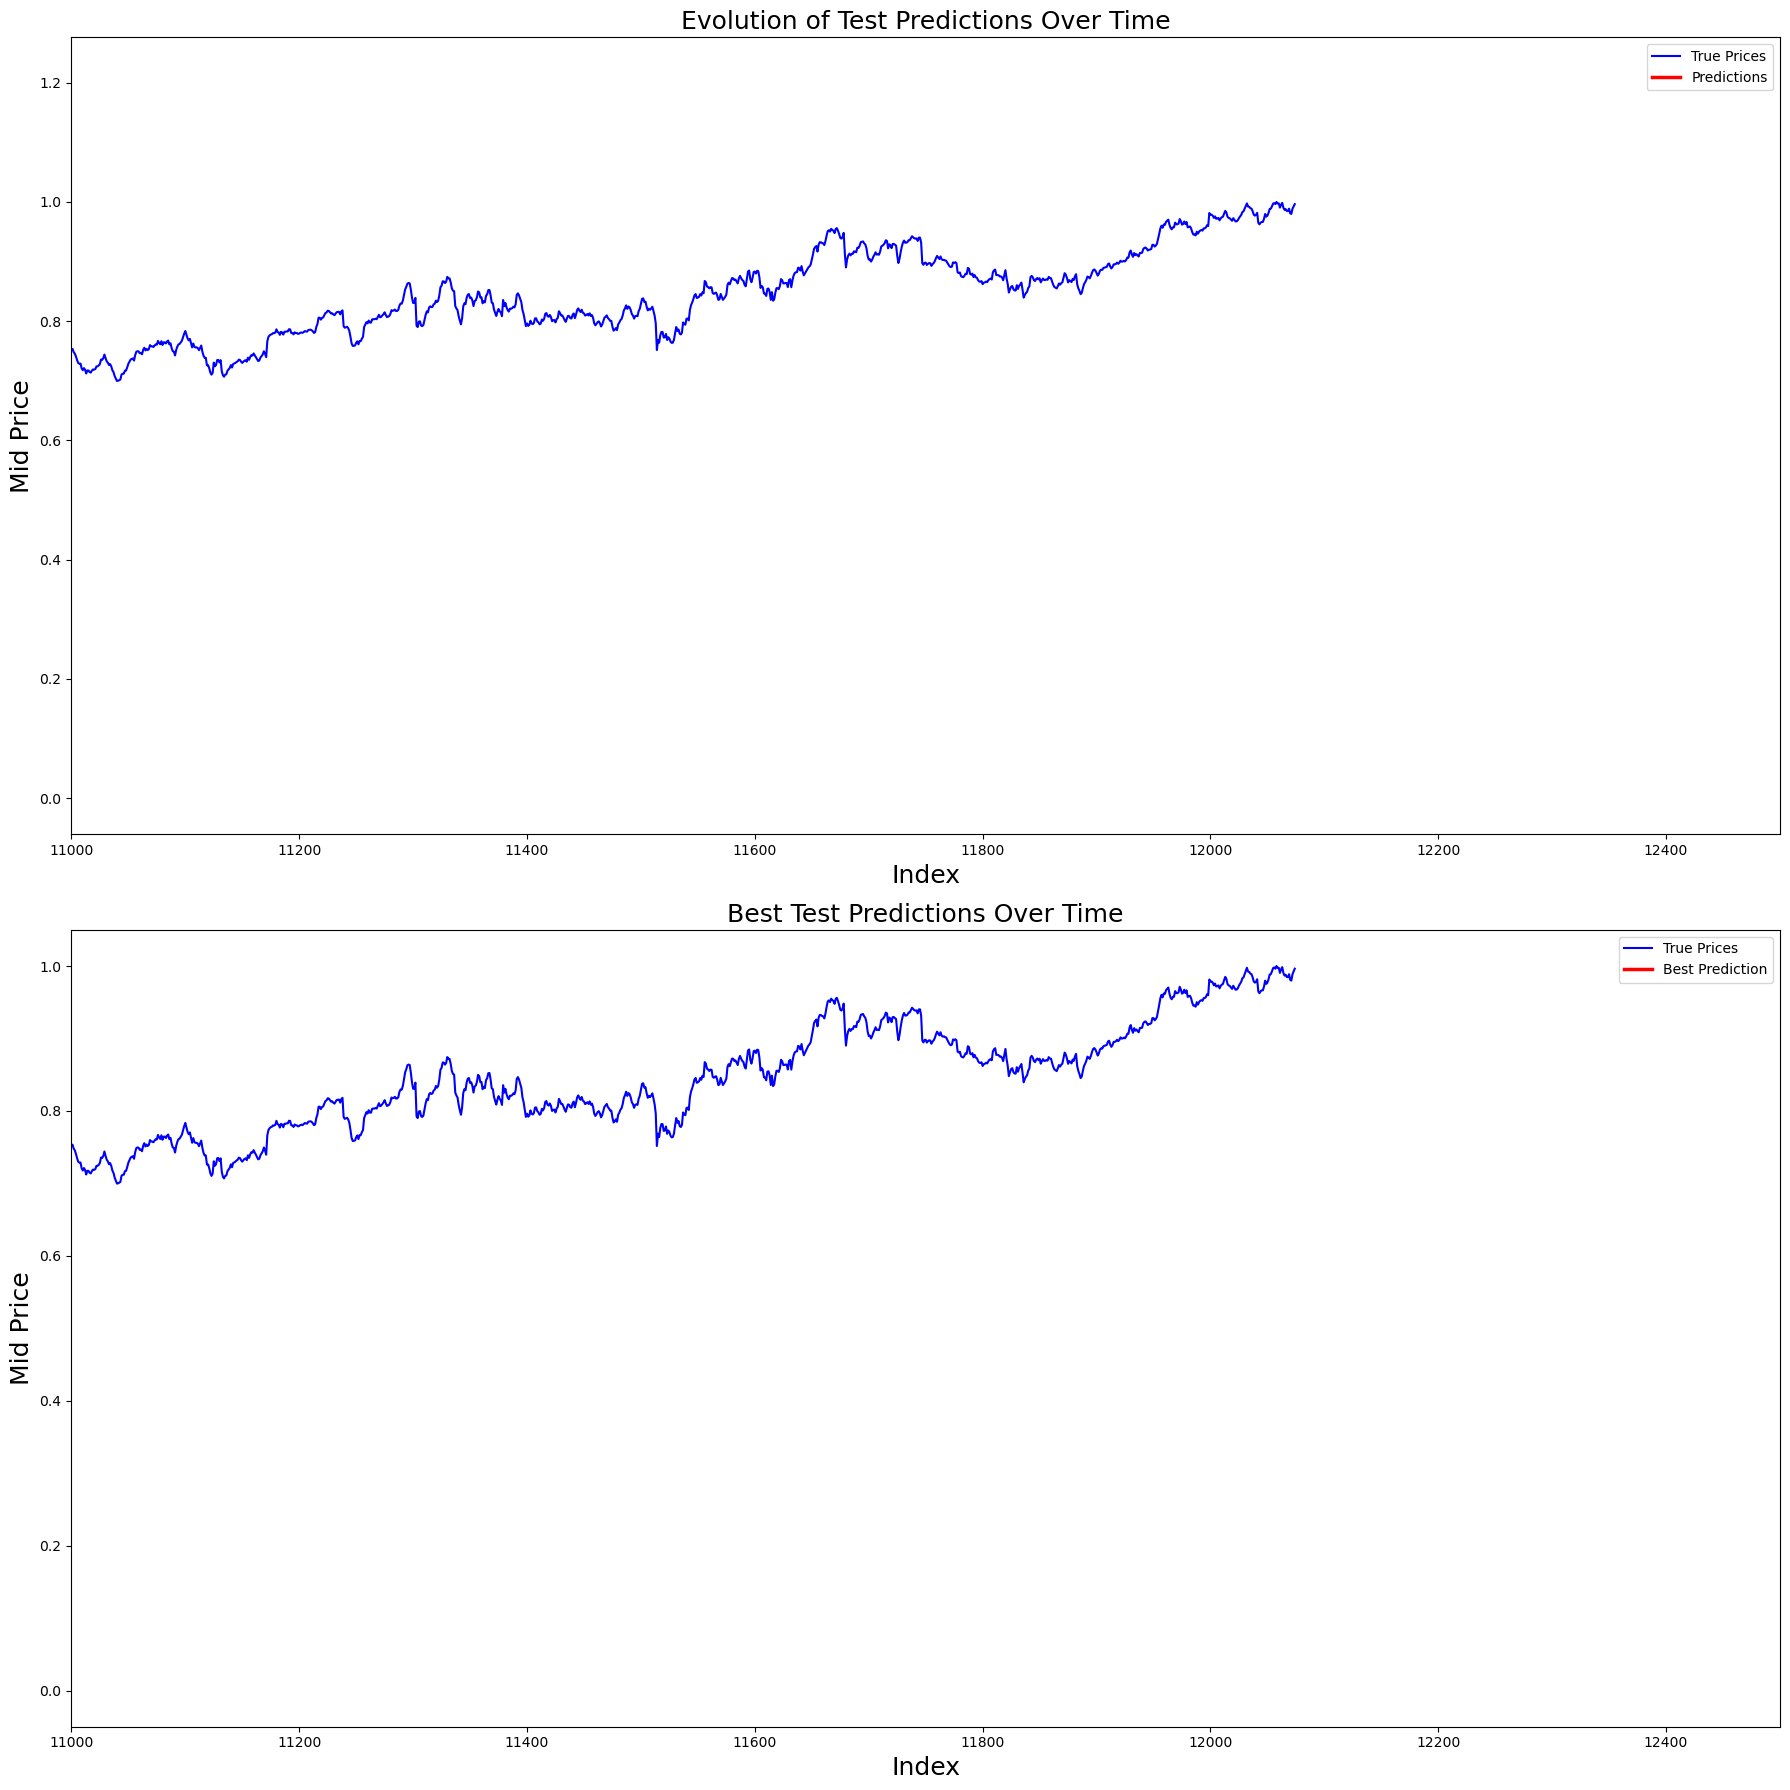

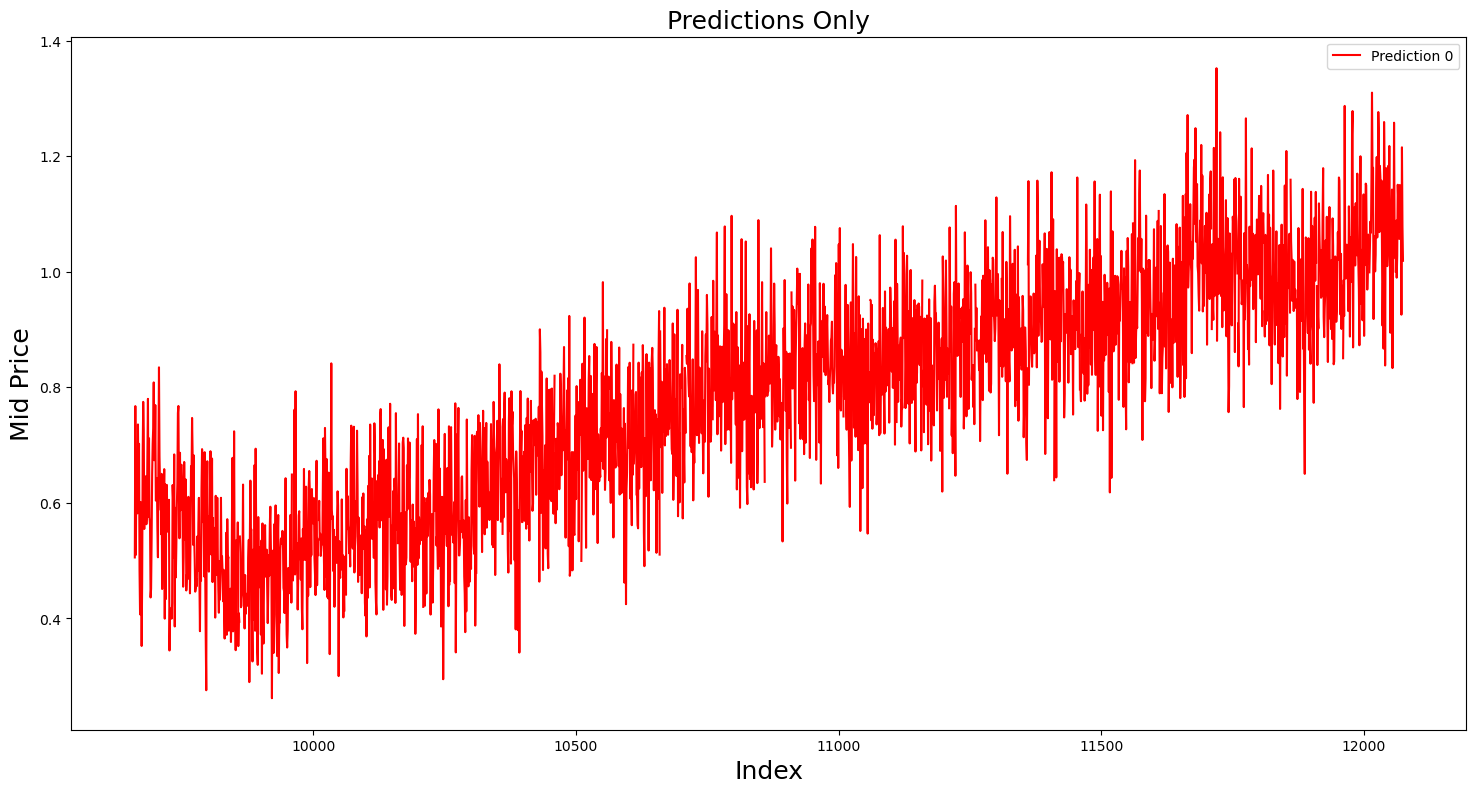

In [81]:
best_prediction_epoch = np.argmin(test_mse_ot)  # Find epoch with the lowest test loss

# Debugging specific index 16
if 16 < len(x_axis_seq) and 16 < len(predictions_seq):
    print(f"Index 16 Debug:")
    print(f"x_axis_seq[16] length: {len(x_axis_seq[16])}")
    print(f"x_axis_seq[16]: {x_axis_seq[16]}")
    print(f"predictions_seq[16] length: {len(predictions_seq[16])}")
    print(f"predictions_seq[16]: {predictions_seq[16]}")
else:
    print("Index 16 is out of bounds or not generated correctly.")

plt.figure(figsize=(18, 18))

# First plot: Evolution of predictions
plt.subplot(2, 1, 1)
plt.plot(range(len(all_mid_data)), all_mid_data, color='b', label='True Prices', zorder=1)  # Plot true prices first

# Plot predictions
for p_i, p in enumerate(predictions_seq[::3]):
    if p_i < len(x_axis_seq) and len(x_axis_seq[p_i]) == len(p):
        plt.plot(x_axis_seq[p_i], p, color='r', alpha=1.0, linewidth=2.5, zorder=2, label='Predictions' if p_i == 0 else "")
    else:
        print(f"Skipping index {p_i} during plotting due to dimension mismatch.")

plt.title('Evolution of Test Predictions Over Time', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.legend()
plt.xlim(11000, 12500)

# Second plot: Best predictions
plt.subplot(2, 1, 2)
plt.plot(range(len(all_mid_data)), all_mid_data, color='b', label='True Prices', zorder=1)  # Plot true prices first

if best_prediction_epoch < len(x_axis_seq):
    if len(x_axis_seq[best_prediction_epoch]) == len(predictions_seq[best_prediction_epoch]):
        plt.plot(
            x_axis_seq[best_prediction_epoch],
            predictions_seq[best_prediction_epoch],
            color='r',
            linewidth=2.5,
            zorder=2,
            label='Best Prediction'
        )
for idx in range(len(predictions_seq)):
    predictions_seq[idx] += 0.05  # Add an offset to predictions
    
plt.title('Best Test Predictions Over Time', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.legend()
plt.xlim(11000, 12500)

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 9))

for p_i, p in enumerate(predictions_seq):
    plt.plot(x_axis_seq[p_i], p, color='r', label=f'Prediction {p_i}' if p_i == 0 else "")

plt.title('Predictions Only', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.legend()
plt.show()


